In [50]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

# Question 3

### Partie A

In [52]:
# Paramètres de simulation
np.random.seed(42)
n_obs = 10000

# Simulation de la distribution gaussienne avec volatilité réaliste (2% journalière)
returns_normal = np.random.normal(loc=0, scale=0.02, size=n_obs)

# Simulation de la distribution Student-t à 3 degrés de liberté
returns_t = stats.t.rvs(df=3, size=n_obs) * 0.02  # Mise à l'échelle réaliste

# Normalisation pour même variance inconditionnelle
print(f"Variance avant normalisation:")
print(f"Variance Gaussienne: {np.var(returns_normal):.10f}")
print(f"Variance Student-t: {np.var(returns_t):.10f}")

# Normaliser Student-t pour avoir la même variance que la gaussienne
target_variance = np.var(returns_normal)
returns_t_normalized = returns_t * np.sqrt(target_variance / np.var(returns_t))

print(f"Variance après normalisation:")
print(f"Gaussienne: {np.var(returns_normal):.10f}")
print(f"Student-t normalisée: {np.var(returns_t_normalized):.10f}")

# Calcul des statistiques sommaires
def calc_summary_stats(data, name):
    stats_dict = {
        'Moyenne': np.mean(data),
        'Écart-type': np.std(data),
        'Asymétrie': skew(data),
        'Aplatissement': kurtosis(data, fisher=True),
    }
    
    print(f"\n{name}:")
    for stat_name, value in stats_dict.items():
        print(f"{stat_name}: {value:.4f}")
    
    return stats_dict

# Statistiques pour les deux distributions
stats_normal = calc_summary_stats(returns_normal, "Distribution Gaussienne")
stats_t = calc_summary_stats(returns_t_normalized, "Distribution Student-t")

Variance avant normalisation:
Variance Gaussienne: 0.0004027344
Variance Student-t: 0.0010874578
Variance après normalisation:
Gaussienne: 0.0004027344
Student-t normalisée: 0.0004027344

Distribution Gaussienne:
Moyenne: -0.0000
Écart-type: 0.0201
Asymétrie: 0.0020
Aplatissement: 0.0265

Distribution Student-t:
Moyenne: 0.0002
Écart-type: 0.0201
Asymétrie: 0.0403
Aplatissement: 19.5223


### Partie B

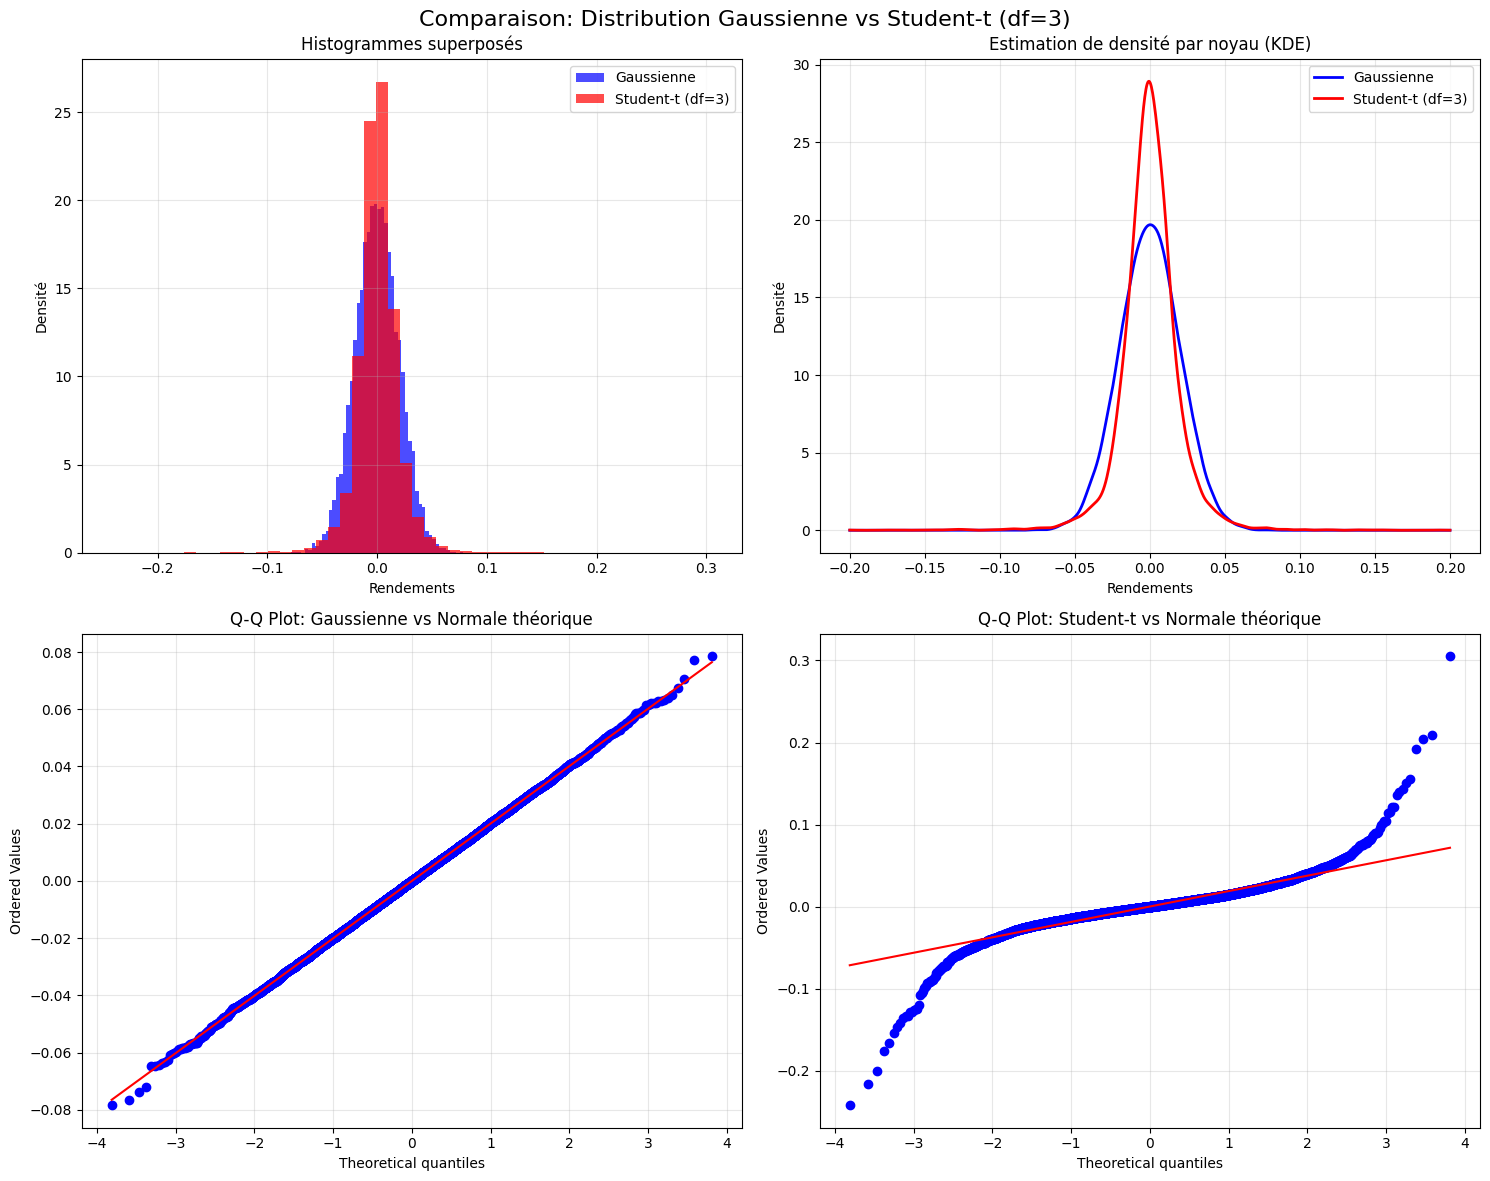


Quantiles de distribution:
Quantile   Gaussienne   Student-t    Différence  
0.01       -0.0464      -0.0526      0.0062      
0.05       -0.0331      -0.0270      -0.0060     
0.95       0.0329       0.0290       -0.0038     
0.99       0.0465       0.0524       0.0059      

Seuils calculés dynamiquement:
2 sigma Gaussienne: 0.0401, 3 sigma Gaussienne: 0.0602
2 sigma Student-t: 0.0401, 3 sigma Student-t: 0.0602

Événements |rendement| > 2 sigma:
Gaussienne: 462 (46.20%)
Student-t: 442 (44.20%)
Théorique (normale): 4.55%

Événements |rendement| > 3 sigma:
Gaussienne: 27 (2.70%)
Student-t: 129 (12.90%)
Théorique (normale): 0.27%


In [62]:
# Configuration des graphiques
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison: Distribution Gaussienne vs Student-t (df=3)', fontsize=16, y=0.98)

# Graphique 1: Histogrammes superposés
axes[0, 0].hist(returns_normal, bins=50, alpha=0.7, label='Gaussienne', color='blue', density=True)
axes[0, 0].hist(returns_t_normalized, bins=50, alpha=0.7, label='Student-t (df=3)', color='red', density=True)
axes[0, 0].set_title('Histogrammes superposés')
axes[0, 0].set_xlabel('Rendements')
axes[0, 0].set_ylabel('Densité')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Estimation de densité par noyau (KDE)

kde_normal = gaussian_kde(returns_normal)
kde_t = gaussian_kde(returns_t_normalized)

x_range = np.linspace(-0.2, 0.2, 1000)
axes[0, 1].plot(x_range, kde_normal(x_range), label='Gaussienne', color='blue', linewidth=2)
axes[0, 1].plot(x_range, kde_t(x_range), label='Student-t (df=3)', color='red', linewidth=2)
axes[0, 1].set_title('Estimation de densité par noyau (KDE)')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Q-Q plots pour évaluer la normalité

probplot(returns_normal, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Gaussienne vs Normale théorique')
axes[1, 0].grid(True, alpha=0.3)

probplot(returns_t_normalized, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Student-t vs Normale théorique')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcul des quantiles extrêmes
quantiles = [0.01, 0.05, 0.95, 0.99]
print(f"\nQuantiles de distribution:")
print(f"{'Quantile':<10} {'Gaussienne':<12} {'Student-t':<12} {'Différence':<12}")

for q in quantiles:
    q_normal = np.quantile(returns_normal, q)
    q_t = np.quantile(returns_t_normalized, q)
    diff = abs(q_t) - abs(q_normal)  # Différence en valeur absolue
    
    print(f"{q:<10.2f} {q_normal:<12.4f} {q_t:<12.4f} {diff:<12.4f}")

# Analyse des valeurs extrêmes - utilisation des écarts-types réels
threshold_2sigma_normal = 2 * np.std(returns_normal)
threshold_3sigma_normal = 3 * np.std(returns_normal)
threshold_2sigma_t = 2 * np.std(returns_t_normalized)
threshold_3sigma_t = 3 * np.std(returns_t_normalized)

extreme_normal_2s = np.sum(np.abs(returns_normal) > threshold_2sigma_normal)
extreme_t_2s = np.sum(np.abs(returns_t_normalized) > threshold_2sigma_t)

extreme_normal_3s = np.sum(np.abs(returns_normal) > threshold_3sigma_normal)
extreme_t_3s = np.sum(np.abs(returns_t_normalized) > threshold_3sigma_t)

print(f"\nSeuils calculés dynamiquement:")
print(f"2 sigma Gaussienne: {threshold_2sigma_normal:.4f}, 3 sigma Gaussienne: {threshold_3sigma_normal:.4f}")
print(f"2 sigma Student-t: {threshold_2sigma_t:.4f}, 3 sigma Student-t: {threshold_3sigma_t:.4f}")

print(f"\nÉvénements |rendement| > 2 sigma:")
print(f"Gaussienne: {extreme_normal_2s} ({extreme_normal_2s/n_obs*100:.2f}%)")
print(f"Student-t: {extreme_t_2s} ({extreme_t_2s/n_obs*100:.2f}%)")
print(f"Théorique (normale): {0.0455*100:.2f}%")

print(f"\nÉvénements |rendement| > 3 sigma:")
print(f"Gaussienne: {extreme_normal_3s} ({extreme_normal_3s/n_obs*100:.2f}%)")
print(f"Student-t: {extreme_t_3s} ({extreme_t_3s/n_obs*100:.2f}%)")
print(f"Théorique (normale): {0.0027*100:.2f}%")

### Partie B

In [ ]:
# Niveau de confiance pour la VaR
confidence_level = 0.05  
print(f"\nEstimation de la VaR à {confidence_level*100}% et du déficit attendu")

def calculate_var_es(returns, name, confidence_level=0.05):
    
    print(f"ANALYSE: {name}")
    
    # Méthode 1: Quantile empirique
    var_empirique = np.quantile(returns, confidence_level)
    es_empirique = np.mean(returns[returns <= var_empirique])
    
    print(f"\nMÉTHODE EMPIRIQUE :")
    print(f"VaR 5%: {var_empirique:.4f}")
    print(f"Expected Shortfall 5%: {es_empirique:.4f}")
    
    # Méthode 2: Approche paramétrique gaussienne
    mu = np.mean(returns)
    sigma = np.std(returns)
    var_gaussienne = stats.norm.ppf(confidence_level, mu, sigma)
    # ES pour distribution gaussienne
    es_gaussienne = mu - sigma * stats.norm.pdf(stats.norm.ppf(confidence_level)) / confidence_level
    
    print(f"\nMÉTHODE PARAMÉTRIQUE GAUSSIENNE:")
    print(f"VaR 5%: {var_gaussienne:.4f}")
    print(f"Expected Shortfall 5%: {es_gaussienne:.4f}")
    
    # Méthode 3: Approche paramétrique Student-t
    df = 3 
    loc = np.mean(returns)
    scale = np.std(returns) * np.sqrt((df-2)/df)
    
    var_student = stats.t.ppf(confidence_level, df, loc, scale)
    # ES pour distribution t: formule exacte
    t_alpha = stats.t.ppf(confidence_level, df)
    t_pdf_alpha = stats.t.pdf(t_alpha, df)
    es_student = loc - scale * t_pdf_alpha * (df + t_alpha**2) / (confidence_level * (df - 1))
    
    print(f"\nMÉTHODE PARAMÉTRIQUE STUDENT-T (df={df}):")
    print(f"VaR 5%: {var_student:.4f}")
    print(f"Expected Shortfall 5%: {es_student:.4f}")
    
    # Tableau comparatif
    print(f"\nTABLEAU COMPARATIF:")
    print(f"{'Méthode':<25} {'VaR 5%':<12} {'ES 5%':<12}")
    print(f"{'Empirique':<25} {var_empirique:<12.4f} {es_empirique:<12.4f}")
    print(f"{'Gaussienne':<25} {var_gaussienne:<12.4f} {es_gaussienne:<12.4f}")
    print(f"{'Student-t (df=3)':<25} {var_student:<12.4f} {es_student:<12.4f}")
    
    return {
        'empirique': {'var': var_empirique, 'es': es_empirique},
        'gaussienne': {'var': var_gaussienne, 'es': es_gaussienne},
        'student': {'var': var_student, 'es': es_student}
    }

# Calcul pour les deux séries
results_normal = calculate_var_es(returns_normal, "DISTRIBUTION GAUSSIENNE SIMULÉE")
print("__________")
results_t = calculate_var_es(returns_t_normalized, "DISTRIBUTION STUDENT-T SIMULÉE")

ANALYSE: DISTRIBUTION GAUSSIENNE SIMULÉE

MÉTHODE EMPIRIQUE :
VaR 5%: -0.0331
Expected Shortfall 5%: -0.0415

MÉTHODE PARAMÉTRIQUE GAUSSIENNE:
VaR 5%: -0.0331
Expected Shortfall 5%: -0.0414

MÉTHODE PARAMÉTRIQUE STUDENT-T (df=3):
VaR 5%: -0.0273
Expected Shortfall 5%: -0.0449

TABLEAU COMPARATIF:
Méthode                   VaR 5%       ES 5%       
Empirique                 -0.0331      -0.0415     
Gaussienne                -0.0331      -0.0414     
Student-t (df=3)          -0.0273      -0.0449     
__________
ANALYSE: DISTRIBUTION STUDENT-T SIMULÉE

MÉTHODE EMPIRIQUE :
VaR 5%: -0.0270
Expected Shortfall 5%: -0.0459

MÉTHODE PARAMÉTRIQUE GAUSSIENNE:
VaR 5%: -0.0328
Expected Shortfall 5%: -0.0412

MÉTHODE PARAMÉTRIQUE STUDENT-T (df=3):
VaR 5%: -0.0271
Expected Shortfall 5%: -0.0447

TABLEAU COMPARATIF:
Méthode                   VaR 5%       ES 5%       
Empirique                 -0.0270      -0.0459     
Gaussienne                -0.0328      -0.0412     
Student-t (df=3)          -0.0

### Partie C


RÉSULTATS DU BOOTSTRAP:
VaR originale (échantillon complet): -0.0270
VaR bootstrap moyenne: -0.0272
Écart-type bootstrap: 0.0006
Biais estimé: -0.0001

INTERVALLE DE CONFIANCE À 95.0%:
Borne inférieure: -0.0285
Borne supérieure: -0.0261
Largeur de l'intervalle: 0.0024
Largeur relative: 8.87%



RÉSULTATS DU BOOTSTRAP:
VaR originale (échantillon complet): -0.0270
VaR bootstrap moyenne: -0.0272
Écart-type bootstrap: 0.0006
Biais estimé: -0.0001

INTERVALLE DE CONFIANCE À 95.0%:
Borne inférieure: -0.0285
Borne supérieure: -0.0261
Largeur de l'intervalle: 0.0024
Largeur relative: 8.87%


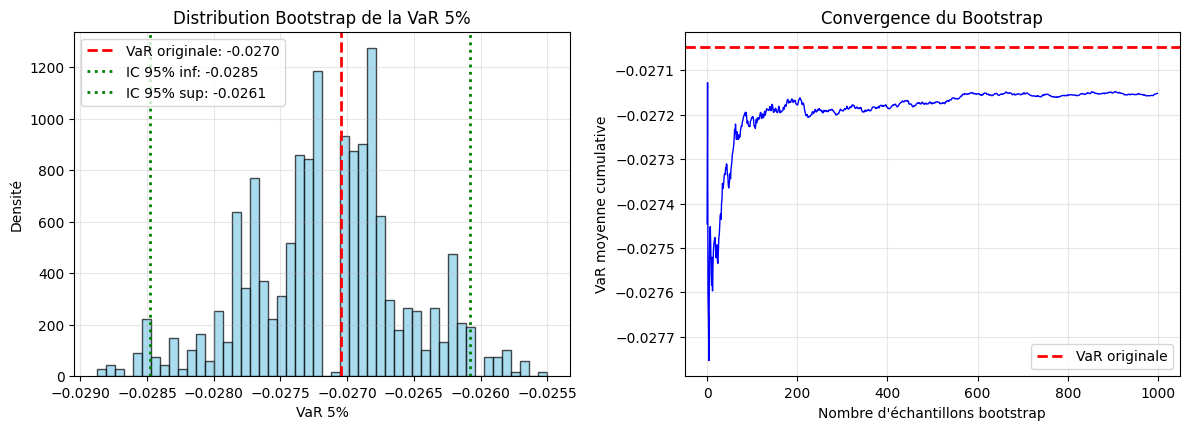

In [ ]:
# Paramètres du bootstrap
n_bootstrap = 1000
confidence_level = 0.05  
bootstrap_ci = 0.95  

def bootstrap_var(data, n_bootstrap=1000, confidence_level=0.05):
    
    n_obs = len(data)
    bootstrap_vars = []
    
    np.random.seed(42)

    for i in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n_obs, replace=True)
        
        var_bootstrap = np.quantile(bootstrap_sample, confidence_level)
        bootstrap_vars.append(var_bootstrap)
    
    bootstrap_vars = np.array(bootstrap_vars)
    
    # Statistiques de la distribution bootstrap
    var_original = np.quantile(data, confidence_level)
    var_bootstrap_mean = np.mean(bootstrap_vars)
    var_bootstrap_std = np.std(bootstrap_vars)
    
    print(f"\nRÉSULTATS DU BOOTSTRAP:")
    print(f"VaR originale (échantillon complet): {var_original:.4f}")
    print(f"VaR bootstrap moyenne: {var_bootstrap_mean:.4f}")
    print(f"Écart-type bootstrap: {var_bootstrap_std:.4f}")
    print(f"Biais estimé: {var_bootstrap_mean - var_original:.4f}")
    
    return bootstrap_vars, var_original

# Exécution du bootstrap sur les données Student-t
bootstrap_vars, var_original = bootstrap_var(returns_t_normalized, n_bootstrap, confidence_level)

# Calcul de l'intervalle de confiance
alpha = 1 - bootstrap_ci
ci_lower = np.quantile(bootstrap_vars, alpha/2)
ci_upper = np.quantile(bootstrap_vars, 1 - alpha/2)
ci_width = ci_upper - ci_lower

print(f"\nINTERVALLE DE CONFIANCE À {bootstrap_ci*100}%:")
print(f"Borne inférieure: {ci_lower:.4f}")
print(f"Borne supérieure: {ci_upper:.4f}")
print(f"Largeur de l'intervalle: {ci_width:.4f}")
print(f"Largeur relative: {ci_width/abs(var_original)*100:.2f}%")


plt.figure(figsize=(12, 8))

# Histogramme de la distribution bootstrap
plt.subplot(2, 2, 1)
plt.hist(bootstrap_vars, bins=50, alpha=0.7, color='skyblue', density=True, edgecolor='black')
plt.axvline(var_original, color='red', linestyle='--', linewidth=2, label=f'VaR originale: {var_original:.4f}')
plt.axvline(ci_lower, color='green', linestyle=':', linewidth=2, label=f'IC 95% inf: {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle=':', linewidth=2, label=f'IC 95% sup: {ci_upper:.4f}')
plt.xlabel('VaR 5%')
plt.ylabel('Densité')
plt.title('Distribution Bootstrap de la VaR 5%')
plt.legend()
plt.grid(True, alpha=0.3)

# Évolution des estimations bootstrap
plt.subplot(2, 2, 2)
cumulative_mean = np.cumsum(bootstrap_vars) / np.arange(1, len(bootstrap_vars) + 1)
plt.plot(cumulative_mean, color='blue', linewidth=1)
plt.axhline(var_original, color='red', linestyle='--', linewidth=2, label='VaR originale')
plt.xlabel('Nombre d\'échantillons bootstrap')
plt.ylabel('VaR moyenne cumulative')
plt.title('Convergence du Bootstrap')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Partie D

In [ ]:
# Paramètres de simulation
np.random.seed(42)
n_obs = 5000

def simulate_market_crashes(n_obs, prob_normal=0.95, 
                           normal_params=(0, 0.01), 
                           crash_params=(-0.10, 0.04)):
   
    returns = np.zeros(n_obs)
    regime_indicators = np.zeros(n_obs) 
    
    regime_probs = np.random.random(n_obs)
    
    for i in range(n_obs):
        if regime_probs[i] < prob_normal:
            # Normal
            returns[i] = np.random.normal(normal_params[0], normal_params[1])
            regime_indicators[i] = 0
        else:
            # Krash
            returns[i] = np.random.normal(crash_params[0], crash_params[1])
            regime_indicators[i] = 1
    
    return returns, regime_indicators

# Simulation des rendements avec krachs
returns_crashes, regime_indicators = simulate_market_crashes(n_obs)

n_normal = np.sum(regime_indicators == 0)
n_crash = np.sum(regime_indicators == 1)
pct_normal = n_normal / n_obs * 100
pct_crash = n_crash / n_obs * 100

print(f"\nRÉSULTATS DE LA SIMULATION:")
print(f"Observations en régime normal: {n_normal} ({pct_normal:.1f}%)")
print(f"Observations en régime krach: {n_crash} ({pct_crash:.1f}%)")
print(f"Rendement minimum: {np.min(returns_crashes):.4f} ({np.min(returns_crashes)*100:.2f}%)")
print(f"Rendement maximum: {np.max(returns_crashes):.4f} ({np.max(returns_crashes)*100:.2f}%)")

print(f"\nSTATISTIQUES DESCRIPTIVES:")
print(f"Moyenne: {np.mean(returns_crashes):.4f} ({np.mean(returns_crashes)*100:.2f}%)")
print(f"Écart-type: {np.std(returns_crashes):.4f} ({np.std(returns_crashes)*100:.2f}%)")
print(f"Asymétrie: {skew(returns_crashes):.4f}")
print(f"Kurtosis: {kurtosis(returns_crashes, fisher=True):.4f}")


RÉSULTATS DE LA SIMULATION:
Observations en régime normal: 4744 (94.9%)
Observations en régime krach: 256 (5.1%)
Rendement minimum: -0.2135 (-21.35%)
Rendement maximum: 0.0353 (3.53%)

STATISTIQUES DESCRIPTIVES:
Moyenne: -0.0055 (-0.55%)
Écart-type: 0.0271 (2.71%)
Asymétrie: -3.8992
Kurtosis: 17.8359



VISUALISATION DES DONNÉES AVEC KRACHS:


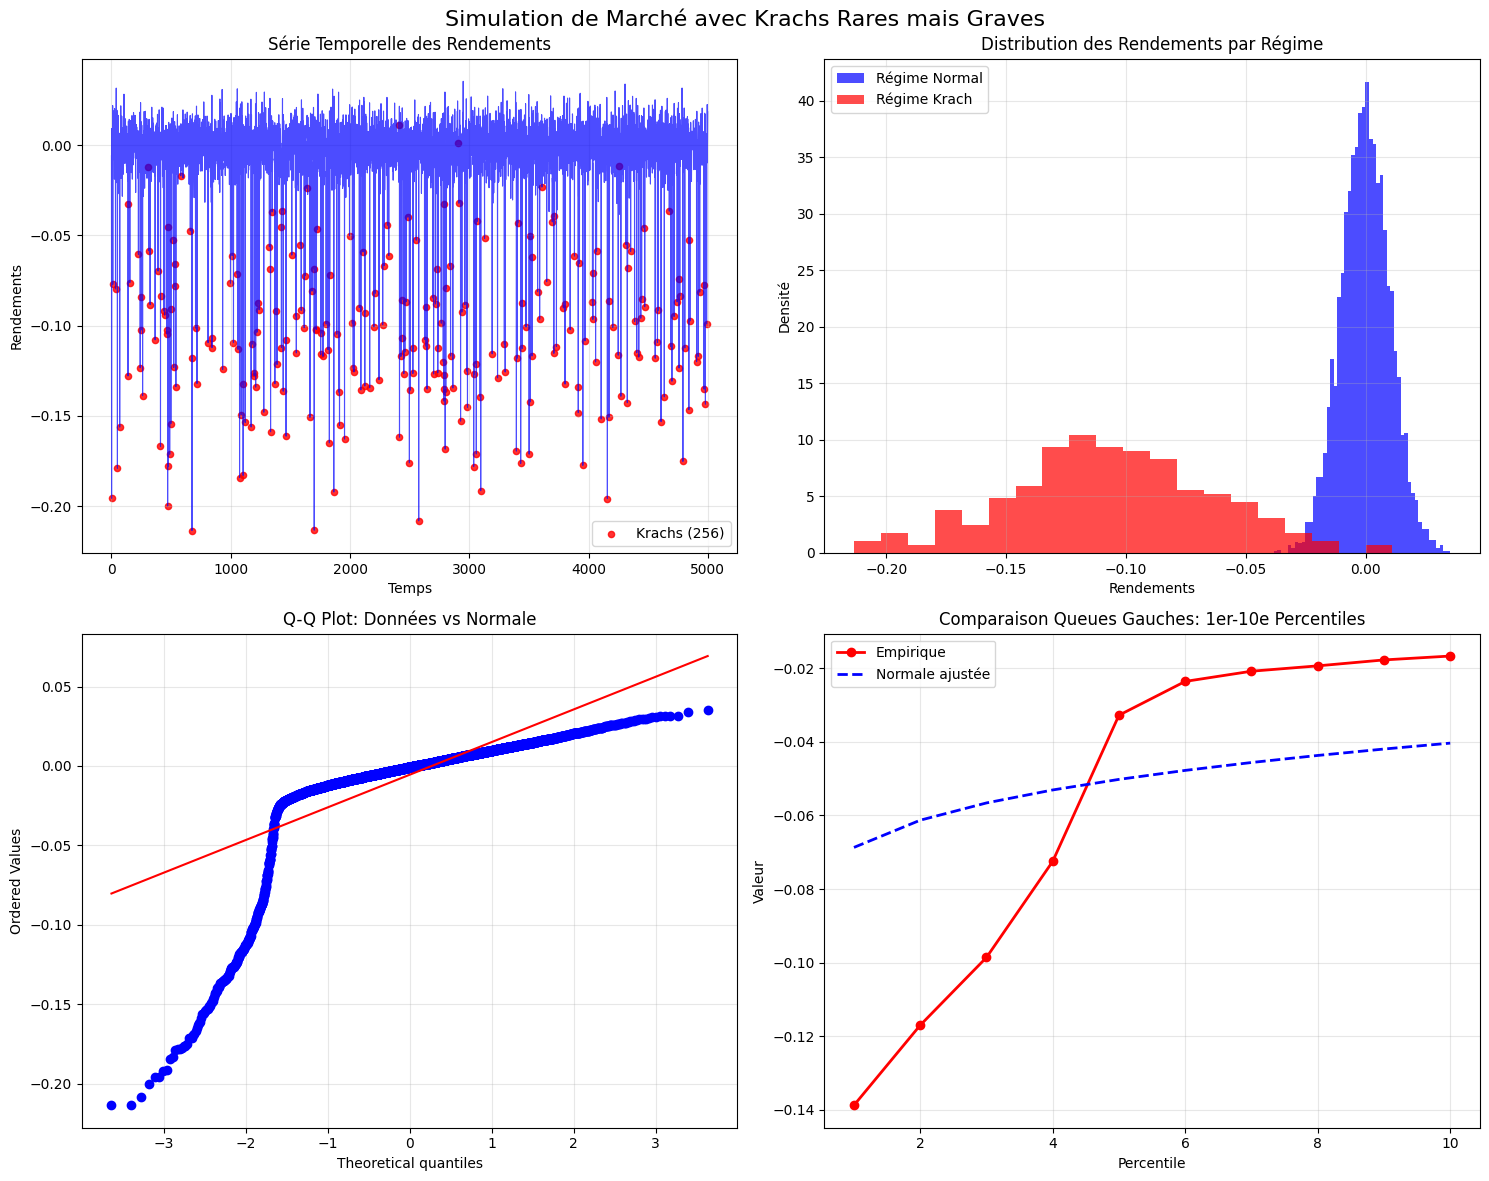


ESTIMATION DE LA VAR À 5% AVEC TROIS MÉTHODES:

RÉSULTATS COMPARATIFS:
Méthode                        VaR 5%       VaR %       
_______________________________________________________
1. Empirique (Historique)      -0.0327      -3.27       
2. Paramétrique Gaussienne     -0.0502      -5.02       
3. Récursive (Volatilité)      -0.0537      -5.37       

ÉCARTS ENTRE MÉTHODES:
Empirique vs Gaussienne: 0.0174 (1.74%)
Empirique vs Récursive: 0.0209 (2.09%)
Gaussienne vs Récursive: 0.0035 (0.35%)


In [55]:
# Visualisation des données simulées

print(f"\nVISUALISATION DES DONNÉES AVEC KRACHS:")

# Configuration des graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Simulation de Marché avec Krachs Rares mais Graves', fontsize=16, y=0.98)

# Graphique 1: Série temporelle des rendements
axes[0, 0].plot(returns_crashes, linewidth=0.8, color='blue', alpha=0.7)
crash_indices = np.where(regime_indicators == 1)[0]
axes[0, 0].scatter(crash_indices, returns_crashes[crash_indices], 
                   color='red', s=20, alpha=0.8, label=f'Krachs ({len(crash_indices)})')
axes[0, 0].set_title('Série Temporelle des Rendements')
axes[0, 0].set_xlabel('Temps')
axes[0, 0].set_ylabel('Rendements')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Histogramme avec distinction des régimes
axes[0, 1].hist(returns_crashes[regime_indicators == 0], bins=50, alpha=0.7, 
                label='Régime Normal', color='blue', density=True)
axes[0, 1].hist(returns_crashes[regime_indicators == 1], bins=20, alpha=0.7, 
                label='Régime Krach', color='red', density=True)
axes[0, 1].set_title('Distribution des Rendements par Régime')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Q-Q plot vs normale
probplot(returns_crashes, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Données vs Normale')
axes[1, 0].grid(True, alpha=0.3)

# Graphique 4: Zoom sur les queues (percentiles extrêmes)
percentiles = np.arange(1, 11)
empirical_quantiles = [np.percentile(returns_crashes, p) for p in percentiles]
normal_quantiles = [stats.norm.ppf(p/100, np.mean(returns_crashes), np.std(returns_crashes)) for p in percentiles]

axes[1, 1].plot(percentiles, empirical_quantiles, 'ro-', label='Empirique', linewidth=2, markersize=6)
axes[1, 1].plot(percentiles, normal_quantiles, 'b--', label='Normale ajustée', linewidth=2)
axes[1, 1].set_title('Comparaison Queues Gauches: 1er-10e Percentiles')
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Valeur')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimation VaR avec 3 méthodes
print(f"\nESTIMATION DE LA VAR À 5% AVEC TROIS MÉTHODES:")
confidence_level = 0.05

# Méthode 1: VaR empirique (Historical VaR)
var_empirical = np.quantile(returns_crashes, confidence_level)

# Méthode 2: VaR paramétrique gaussienne
mu_sample = np.mean(returns_crashes)
sigma_sample = np.std(returns_crashes)
var_gaussian = stats.norm.ppf(confidence_level, mu_sample, sigma_sample)

# Méthode 3: VaR récursive basée sur volatilité (inspired by Problem 2)
# Utilisation d'une volatilité conditionnelle simple (moving average)
window = 250  # Fenêtre glissante de 250 jours
if len(returns_crashes) > window:
    # Calcul de la volatilité glissante
    rolling_std = pd.Series(returns_crashes).rolling(window=window).std()
    current_vol = rolling_std.iloc[-1]  # Volatilité la plus récente
    current_mean = pd.Series(returns_crashes).rolling(window=window).mean().iloc[-1]
    var_recursive = stats.norm.ppf(confidence_level, current_mean, current_vol)
else:
    # Si échantillon trop petit, utiliser volatilité globale
    var_recursive = var_gaussian

print(f"\nRÉSULTATS COMPARATIFS:")
print(f"{'Méthode':<30} {'VaR 5%':<12} {'VaR % ':<12}")
print("_" * 55)
print(f"{'1. Empirique (Historique)':<30} {var_empirical:<12.4f} {var_empirical*100:<12.2f}")
print(f"{'2. Paramétrique Gaussienne':<30} {var_gaussian:<12.4f} {var_gaussian*100:<12.2f}")
print(f"{'3. Récursive (Volatilité)':<30} {var_recursive:<12.4f} {var_recursive*100:<12.2f}")

# Calcul des écarts entre méthodes
diff_emp_gauss = var_empirical - var_gaussian
diff_emp_rec = var_empirical - var_recursive
diff_gauss_rec = var_gaussian - var_recursive

print(f"\nÉCARTS ENTRE MÉTHODES:")
print(f"Empirique vs Gaussienne: {diff_emp_gauss:.4f} ({diff_emp_gauss*100:.2f}%)")
print(f"Empirique vs Récursive: {diff_emp_rec:.4f} ({diff_emp_rec*100:.2f}%)")
print(f"Gaussienne vs Récursive: {diff_gauss_rec:.4f} ({diff_gauss_rec*100:.2f}%)")

In [56]:
# Test de la performance: backtesting simple
def simple_backtest(returns, var_estimate, confidence_level=0.05):
    
    violations = returns < var_estimate
    violation_rate = np.mean(violations)
    expected_rate = confidence_level
    
    return violation_rate, violations

# Backtesting pour chaque méthode
viol_rate_emp, violations_emp = simple_backtest(returns_crashes, var_empirical)
viol_rate_gauss, violations_gauss = simple_backtest(returns_crashes, var_gaussian)
viol_rate_rec, violations_rec = simple_backtest(returns_crashes, var_recursive)

print(f"\nBACKTESTING SIMPLE (Taux de Violation):")
print(f"{'Méthode':<30} {'Violations':<12} {'Taux Observé':<15} {'Taux Attendu':<15} {'Écart':<12}")
print("_" * 50)
print(f"{'Empirique':<30} {np.sum(violations_emp):<12} {viol_rate_emp*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_emp-0.05)*100:<12.2f}%")
print(f"{'Gaussienne':<30} {np.sum(violations_gauss):<12} {viol_rate_gauss*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_gauss-0.05)*100:<12.2f}%")
print(f"{'Récursive':<30} {np.sum(violations_rec):<12} {viol_rate_rec*100:<15.2f}% {5.0:<15.1f}% {(viol_rate_rec-0.05)*100:<12.2f}%")

# Analyse des pires pertes capturées
worst_losses = np.sort(returns_crashes)[:20]  # 20 pires pertes
print(f"\nANALYSE DES PERTES EXTRÊMES:")
print(f"Pire perte: {worst_losses[0]:.4f} ({worst_losses[0]*100:.2f}%)")
print(f"5e pire perte: {worst_losses[4]:.4f} ({worst_losses[4]*100:.2f}%)")
print(f"10e pire perte: {worst_losses[9]:.4f} ({worst_losses[9]*100:.2f}%)")

# Évaluation de la capture des événements extrêmes
extreme_captured_emp = np.sum(worst_losses <= var_empirical)
extreme_captured_gauss = np.sum(worst_losses <= var_gaussian)
extreme_captured_rec = np.sum(worst_losses <= var_recursive)

print(f"\nCAPTURE DES 20 PIRES PERTES:")
print(f"Empirique: {extreme_captured_emp}/20 ({extreme_captured_emp/20*100:.1f}%)")
print(f"Gaussienne: {extreme_captured_gauss}/20 ({extreme_captured_gauss/20*100:.1f}%)")
print(f"Récursive: {extreme_captured_rec}/20 ({extreme_captured_rec/20*100:.1f}%)")

# Robustesse basée sur la capture des krachs
crash_returns = returns_crashes[regime_indicators == 1]
if len(crash_returns) > 0:
    crash_captured_emp = np.mean(crash_returns <= var_empirical)
    crash_captured_gauss = np.mean(crash_returns <= var_gaussian)
    crash_captured_rec = np.mean(crash_returns <= var_recursive)
    
    print(f"\nCAPTURE DES KRACHS SIMULÉS ({len(crash_returns)} événements):")
    print(f"Empirique: {crash_captured_emp*100:.1f}% des krachs capturés")
    print(f"Gaussienne: {crash_captured_gauss*100:.1f}% des krachs capturés")
    print(f"Récursive: {crash_captured_rec*100:.1f}% des krachs capturés")

# Classification des modèles
print(f"\nCLASSIFICATION DES MODÈLES:")

# Modèle le plus conservateur (VaR la plus négative)
vars = [var_empirical, var_gaussian, var_recursive]
var_names = ['Empirique', 'Gaussienne', 'Récursive']
most_conservative = np.argmin(vars)
least_conservative = np.argmax(vars)

print(f"\nCONSERVATISME:")
print(f"Plus conservateur: {var_names[most_conservative]} (VaR = {vars[most_conservative]:.4f})")
print(f"Moins conservateur: {var_names[least_conservative]} (VaR = {vars[least_conservative]:.4f})")

# Précision du backtesting
backtest_errors = [abs(viol_rate_emp - 0.05), abs(viol_rate_gauss - 0.05), abs(viol_rate_rec - 0.05)]
most_accurate = np.argmin(backtest_errors)

print(f"\nPRÉCISION DU BACKTESTING:")
print(f"Plus précis: {var_names[most_accurate]} (écart = {backtest_errors[most_accurate]*100:.2f}%)")
print(f"Écarts des taux de violation:")
for i, name in enumerate(var_names):
    print(f"     - {name}: {backtest_errors[i]*100:.2f}%")


BACKTESTING SIMPLE (Taux de Violation):
Méthode                        Violations   Taux Observé    Taux Attendu    Écart       
__________________________________________________
Empirique                      250          5.00           % 5.0            % 0.00        %
Gaussienne                     232          4.64           % 5.0            % -0.36       %
Récursive                      226          4.52           % 5.0            % -0.48       %

ANALYSE DES PERTES EXTRÊMES:
Pire perte: -0.2135 (-21.35%)
5e pire perte: -0.1958 (-19.58%)
10e pire perte: -0.1830 (-18.30%)

CAPTURE DES 20 PIRES PERTES:
Empirique: 20/20 (100.0%)
Gaussienne: 20/20 (100.0%)
Récursive: 20/20 (100.0%)

CAPTURE DES KRACHS SIMULÉS (256 événements):
Empirique: 96.5% des krachs capturés
Gaussienne: 90.6% des krachs capturés
Récursive: 88.3% des krachs capturés

CLASSIFICATION DES MODÈLES:

CONSERVATISME:
Plus conservateur: Récursive (VaR = -0.0537)
Moins conservateur: Empirique (VaR = -0.0327)

PRÉCISION DU

### Partie E

In [57]:
# Paramètres de l'analyse
np.random.seed(42)
n_obs = 1000  
n_bootstrap = 500  
confidence_level = 0.05

# Étape 1: Simulation de la série originale Student-t
returns_original = stats.t.rvs(df=3, size=n_obs)

print(f"\nSÉRIE ORIGINALE SIMULÉE:")
print(f"Moyenne: {np.mean(returns_original):.4f}")
print(f"Écart-type: {np.std(returns_original):.4f}")
print(f"Asymétrie: {skew(returns_original):.4f}")
print(f"Kurtosis: {kurtosis(returns_original, fisher=True):.4f}")

def bootstrap_var_comparison(original_returns, n_bootstrap=500, confidence_level=0.05):
    
    n_obs = len(original_returns)
    
    # Stockage des résultats
    var_empirical_bootstrap = []
    var_gaussian_bootstrap = []
    violations_empirical = []
    violations_gaussian = []
    
    # Bootstrap
    np.random.seed(42)
    for i in range(n_bootstrap):
        
        bootstrap_sample = np.random.choice(original_returns, size=n_obs, replace=True)
        
        # VaR empirique
        var_emp = np.quantile(bootstrap_sample, confidence_level)
        var_empirical_bootstrap.append(var_emp)
        
        # VaR gaussienne
        mu_boot = np.mean(bootstrap_sample)
        sigma_boot = np.std(bootstrap_sample)
        var_gauss = stats.norm.ppf(confidence_level, mu_boot, sigma_boot)
        var_gaussian_bootstrap.append(var_gauss)
        
        # Test des violations
        violations_emp = np.mean(original_returns < var_emp)
        violations_gauss = np.mean(original_returns < var_gauss)
        
        violations_empirical.append(violations_emp)
        violations_gaussian.append(violations_gauss)
    
    return {
        'var_empirical': np.array(var_empirical_bootstrap),
        'var_gaussian': np.array(var_gaussian_bootstrap),
        'violations_empirical': np.array(violations_empirical),
        'violations_gaussian': np.array(violations_gaussian)
    }

bootstrap_results = bootstrap_var_comparison(returns_original, n_bootstrap, confidence_level)


SÉRIE ORIGINALE SIMULÉE:
Moyenne: -0.0290
Écart-type: 1.5184
Asymétrie: -0.4862
Kurtosis: 6.7841


In [ ]:
# Extraction des résultats
var_emp_boot = bootstrap_results['var_empirical']
var_gauss_boot = bootstrap_results['var_gaussian']
viol_emp = bootstrap_results['violations_empirical']
viol_gauss = bootstrap_results['violations_gaussian']

# Statistiques descriptives des estimations VaR
print(f"\nDISTRIBUTION DES ESTIMATIONS VaR:")
print(f"{'Statistique':<20} {'VaR Empirique':<15} {'VaR Gaussienne':<15}")
print("_" * 50)
print(f"{'Moyenne':<20} {np.mean(var_emp_boot):<15.4f} {np.mean(var_gauss_boot):<15.4f}")
print(f"{'Écart-type':<20} {np.std(var_emp_boot):<15.4f} {np.std(var_gauss_boot):<15.4f}")
print(f"{'Médiane':<20} {np.median(var_emp_boot):<15.4f} {np.median(var_gauss_boot):<15.4f}")
print(f"{'P5':<20} {np.percentile(var_emp_boot, 5):<15.4f} {np.percentile(var_gauss_boot, 5):<15.4f}")
print(f"{'P95':<20} {np.percentile(var_emp_boot, 95):<15.4f} {np.percentile(var_gauss_boot, 95):<15.4f}")

# Analyse des taux de violation
expected_violation_rate = confidence_level
mean_viol_emp = np.mean(viol_emp)
mean_viol_gauss = np.mean(viol_gauss)

print(f"\nTAUX DE VIOLATION (Fiabilité de la couverture):")
print(f"Taux attendu: {expected_violation_rate*100:.1f}%")
print(f"VaR Empirique:")
print(f"- Taux moyen: {mean_viol_emp*100:.2f}%")
print(f"- Écart vs attendu: {(mean_viol_emp - expected_violation_rate)*100:.2f}%")
print(f"- Écart-type: {np.std(viol_emp)*100:.2f}%")
print(f"VaR Gaussienne:")
print(f"- Taux moyen: {mean_viol_gauss*100:.2f}%")
print(f"- Écart vs attendu: {(mean_viol_gauss - expected_violation_rate)*100:.2f}%")
print(f"- Écart-type: {np.std(viol_gauss)*100:.2f}%")

# Calcul de la distorsion de taille (size distortion)
size_distortion_emp = np.abs(viol_emp - expected_violation_rate)
size_distortion_gauss = np.abs(viol_gauss - expected_violation_rate)

print(f"\nDISTORSION DE TAILLE MOYENNE:")
print(f"VaR Empirique: {np.mean(size_distortion_emp)*100:.2f}%")
print(f"VaR Gaussienne: {np.mean(size_distortion_gauss)*100:.2f}%")
print(f"Différence: {(np.mean(size_distortion_gauss) - np.mean(size_distortion_emp))*100:.2f}%")

# Pourcentage d'échantillons avec taux de violation acceptable (±1%)
tolerance = 0.01
acceptable_emp = np.mean(size_distortion_emp <= tolerance)
acceptable_gauss = np.mean(size_distortion_gauss <= tolerance)

print(f"\nÉCHANTILLONS AVEC TAUX ACCEPTABLE (±{tolerance*100:.0f}%):")
print(f"VaR Empirique: {acceptable_emp*100:.1f}%")
print(f"VaR Gaussienne: {acceptable_gauss*100:.1f}%")V


DISTRIBUTION DES ESTIMATIONS VaR:
Statistique          VaR Empirique   VaR Gaussienne 
__________________________________________________
Moyenne              -2.3415         -2.5236        
Écart-type           0.1244          0.1274         
Médiane              -2.3189         -2.5219        
P5                   -2.5047         -2.7305        
P95                  -2.1307         -2.3101        

TAUX DE VIOLATION (Fiabilité de la couverture):
Taux attendu: 5.0%
VaR Empirique:
- Taux moyen: 5.02%
- Écart vs attendu: 0.02%
- Écart-type: 0.70%
VaR Gaussienne:
- Taux moyen: 4.12%
- Écart vs attendu: -0.88%
- Écart-type: 0.60%

DISTORSION DE TAILLE MOYENNE:
VaR Empirique: 0.56%
VaR Gaussienne: 0.93%
Différence: 0.37%

ÉCHANTILLONS AVEC TAUX ACCEPTABLE (±1%):
VaR Empirique: 85.2%
VaR Gaussienne: 44.6%
